# Introduction

This notebook is for modeling on `data_cleaned.csv` from `cleaning.ipynb`.

In [1]:
import pandas as pd
pd.set_option("max_columns", None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc

import sys
import six
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# General Helper Functions

In [2]:
# Returns top-N values for all columns in ls.
def many_count(ls, df, n=5):
    for i in ls:
        print(df[i].value_counts(normalize=True).iloc[:n])
        print('---------------')

In [3]:
# Returns all unique values for columns in ls.
def many_unique(ls, df):
    for i in ls:
        print(df[i].unique())
        print('---------------')

In [4]:
# Creates dummies of top-N most common values in column and drops original.
def top_dummies(ls, df, n=5, drop=True):
    for x in ls:
        for i in df[x].value_counts().index[:n]:
            df[x + "_" + i.replace(" ", "_")] = (df[x] == i).astype(int)
        if drop == True:
            df.drop(x, axis=1, inplace=True)

In [5]:
# Evaluates model performance with multiple metrics
def model_judge(model, X, y):
    model_labels = ['func', 'func need repair', 'nonfunc']
    print(classification_report(y, model.predict(X), target_names=model_labels))
    plot_confusion_matrix(model, X, y)

# Importing Data

In [6]:
df = pd.read_csv('../data/data_cleaned.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity,source,waterpoint_type,status_group,day_of_year,month
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,vwc,pay annually,good,enough,spring,communal standpipe,functional,73,3
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,65,3
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,vwc,pay per bucket,good,enough,dam,communal standpipe multiple,functional,56,2
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,True,1986,submersible,vwc,never pay,good,dry,machine dbh,communal standpipe multiple,non functional,28,1
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,WUA,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,194,7


# General Preprocessing

## Replacing Target Values

In [7]:
df.status_group.replace({'functional':0, 'functional needs repair':1, 'non functional':2}, inplace=True)
df.status_group.unique()

array([0, 2, 1], dtype=int64)

## Creating Selected Dummies

In the section below, I'm going to sort out the categorical columns from the continuous and select which categorical columns to make dummies out of. There are too many to reasonably do it for all of them, so some executive choices must be made. If the models end up performing poorly, this step may be revisited and done differently.

In [26]:
cats = []
for i in df.columns:
    if (type(df[i][0]) != np.int64) & (type(df[i][0]) != np.float64):
        cats.append(i)

print(len(cats))
print(cats)

19
['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type_class', 'management', 'payment', 'quality_group', 'quantity', 'source', 'waterpoint_type']


In [27]:
conts = [i for i in df.columns if i not in cats]

print(len(conts))
print(conts)

12
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'status_group', 'day_of_year', 'month']


In [28]:
many_count(cats, df)

Government Of Tanzania    0.162903
Danida                    0.056125
Hesawa                    0.039472
Rwssp                     0.024971
Kkkt                      0.023056
Name: funder, dtype: float64
---------------
DWE           0.312474
Government    0.032882
RWE           0.021955
DANIDA        0.018906
Commu         0.016297
Name: installer, dtype: float64
---------------
none         0.060292
Shuleni      0.029037
Zahanati     0.013739
Msikitini    0.009029
Kanisani     0.005302
Name: wpt_name, dtype: float64
---------------
Lake Victoria      0.173440
Pangani            0.151451
Rufiji             0.135120
Internal           0.131884
Lake Tanganyika    0.108963
Name: basin, dtype: float64
---------------
Madukani    0.008606
Shuleni     0.008572
Majengo     0.008504
Kati        0.006319
Mtakuja     0.004438
Name: subvillage, dtype: float64
---------------
Iringa         0.089685
Shinyanga      0.084399
Mbeya          0.078588
Kilimanjaro    0.074184
Morogoro       0.067865
Na

Columns to be given 5 dummies: `extraction_type_class` (because of relationship to function of well)

Columns to be given 2 dummies: `management` (because EDA suggested relationship between top management values and well failure), `quality_group` (same as previous but with water quality), `waterpoint_type` (because of relationship to function of well)

Columns to make binary of top value: `public_meeting`, `permit`, `payment`, `funder`, `installer`

> *Next columns in the batting order to be tried out if these fail:* `source`, `quantity`, `basin`

The cells below replace the aforementioned columns with their set amount of dummies and drops all remaining object columns in the DataFrame.

In [29]:
five_dum = ['extraction_type_class']
two_dum = ['management', 'quality_group', 'waterpoint_type']
one_dum = ['payment', 'funder', 'installer']
one_dum_already_bool = ['public_meeting', 'permit']

In [30]:
dum_df = df.copy()

In [31]:
top_dummies(five_dum, dum_df, n=5)
top_dummies(two_dum, dum_df, n=2)
top_dummies(one_dum, dum_df, n=1)

In [32]:
for i in one_dum_already_bool:
    dum_df[i] = dum_df[i].astype('int')

In [33]:
for i in dum_df.columns:
    if dum_df[i].dtype == 'O':
        dum_df.drop(i, axis=1, inplace=True)

In [34]:
dum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59029 entries, 0 to 59028
Data columns (total 28 columns):
id                                    59029 non-null int64
amount_tsh                            59029 non-null float64
gps_height                            59029 non-null int64
longitude                             59029 non-null float64
latitude                              59029 non-null float64
region_code                           59029 non-null int64
district_code                         59029 non-null int64
population                            59029 non-null int64
public_meeting                        59029 non-null int32
permit                                59029 non-null int32
construction_year                     59029 non-null int64
status_group                          59029 non-null int64
day_of_year                           59029 non-null int64
month                                 59029 non-null int64
extraction_type_class_gravity         59029 non-null int32


In [35]:
np.sum(dum_df.dtypes == 'O')

0

In [36]:
dum_df.head()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,status_group,day_of_year,month,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_submersible,extraction_type_class_motorpump,management_vwc,management_wug,quality_group_good,quality_group_salty,waterpoint_type_communal_standpipe,waterpoint_type_hand_pump,payment_never_pay,funder_Government_Of_Tanzania,installer_DWE
0,69572,6000.0,1390,34.938093,-9.856322,11,5,109,1,0,1999,0,73,3,1,0,0,0,0,1,0,1,0,1,0,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,20,2,280,1,1,2010,0,65,3,1,0,0,0,0,0,1,1,0,1,0,1,0,0
2,34310,25.0,686,37.460664,-3.821329,21,4,250,1,1,2009,0,56,2,1,0,0,0,0,1,0,1,0,0,0,0,0,0
3,67743,0.0,263,38.486161,-11.155298,90,63,58,1,1,1986,2,28,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
4,19728,0.0,0,31.130847,-1.825359,18,1,0,1,1,0,0,194,7,1,0,0,0,0,0,0,1,0,1,0,1,0,0


Beautiful numbers only! Now we can pass these numerics to Sklearn and see how the baseline models perform.

# Test-Train Split

In [37]:
X = dum_df.drop("status_group", axis=1)
y = dum_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Baseline Model

I'm doing a KNN baseline model because this data has a fair amount of geographic data still in it, despite having dropped `region` and `ward` previously. We still have height, lat, long, and other geographic codes.

In [38]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
knn.score(X_test, y_test)

0.5206667570131455

                  precision    recall  f1-score   support

            func       0.57      0.71      0.63      8024
func need repair       0.08      0.02      0.03      1062
         nonfunc       0.44      0.35      0.39      5672

        accuracy                           0.52     14758
       macro avg       0.36      0.36      0.35     14758
    weighted avg       0.48      0.52      0.49     14758



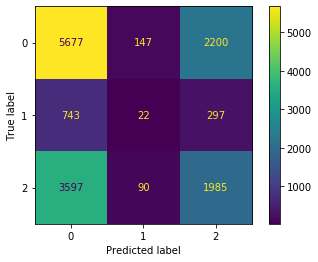

In [40]:
model_judge(knn, X_test, y_test)

This isn't great, only **2%** better accuracy than just guessing. Scaling the data and tweaking hyperparameters should help this.

# Further Model Training

The same process will be followed on all models:
1. Make a Pipeline.
1. Run it through a GridSearchCV.
1. Use the best parameters to fit our model.
1. Score the model.

## K Nearest Neighbors

### Training

In [36]:
knn_pipe = Pipeline([('SS' , StandardScaler()),
                     ('KN' , KNeighborsClassifier())])

In [37]:
knn_grid = [{'KN__n_neighbors' : [2, 5, 8, 11, 14]}]

In [38]:
knn_gridsearch = GridSearchCV(estimator=knn_pipe, param_grid=knn_grid, scoring='accuracy', cv=3)

In [64]:
knn_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('SS',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=7, p=2,
                                                             weights='uniform'))],
                                verbose=False),


In [65]:
knn_gridsearch.best_params_

{'KN__n_neighbors': 8}

In [40]:
knn_pipe['KN'].n_neighbors = 8

In [50]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('SS', StandardScaler()),
                ('KN', KNeighborsClassifier(n_neighbors=8))])

### Scoring

                  precision    recall  f1-score   support

            func       0.70      0.85      0.77      8024
func need repair       0.44      0.18      0.25      1062
         nonfunc       0.73      0.58      0.65      5672

        accuracy                           0.70     14758
       macro avg       0.62      0.54      0.56     14758
    weighted avg       0.69      0.70      0.69     14758



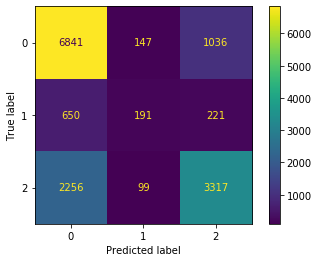

In [53]:
model_judge(knn_pipe, X_test, y_test)

Biggest problem is with value `2256`, wells that were predicted class 0 (functional), but were actually class 2 (nonfunctional). This fundamentally undermines the goal of trying to help people access water. Let's see if synthetic resampling helps.

### KNN and SMOTE

In [54]:
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Steven\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [56]:
knn_pipe.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('SS', StandardScaler()),
                ('KN', KNeighborsClassifier(n_neighbors=8))])

                  precision    recall  f1-score   support

            func       0.72      0.78      0.75      8024
func need repair       0.25      0.38      0.30      1062
         nonfunc       0.73      0.57      0.64      5672

        accuracy                           0.67     14758
       macro avg       0.57      0.58      0.57     14758
    weighted avg       0.69      0.67      0.68     14758



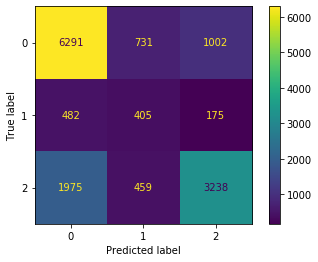

In [57]:
model_judge(knn_pipe, X_test, y_test)

There's a slight overall decrease in accuracy here. The confusion matrix shows promising results, however: The bottom-left square (nonfunctional wells falsely labeled as functional) has gone down. This model is decent but we're gonna keep digging.

## Decision Tree

In [59]:
tree_pipe = Pipeline([('SS' , StandardScaler()),
                      ('TR', DecisionTreeClassifier(random_state=0))])

In [62]:
tree_grid = [{'TR__max_depth' : [None, 5, 10, 15]},
             {'TR__min_samples_split' : [2, 10, 20]},
             {'TR__min_samples_leaf' : [1, 5, 10]}]

In [63]:
tree_gridsearch = GridSearchCV(estimator=tree_pipe, param_grid=tree_grid, scoring='accuracy', cv=3)

In [64]:
tree_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('SS', StandardScaler()),
                                       ('TR',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid=[{'TR__max_depth': [None, 5, 10, 15]},
                         {'TR__min_samples_split': [2, 10, 20]},
                         {'TR__min_samples_leaf': [1, 5, 10]}],
             scoring='accuracy')

In [69]:
tree_gridsearch.best_params_

{'TR__min_samples_leaf': 10}

In [70]:
tree_pipe['TR'].min_samples_leaf = 10

In [71]:
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('SS', StandardScaler()),
                ('TR',
                 DecisionTreeClassifier(min_samples_leaf=10, random_state=0))])

### Scoring

                  precision    recall  f1-score   support

            func       0.74      0.80      0.77      8024
func need repair       0.45      0.27      0.34      1062
         nonfunc       0.71      0.68      0.69      5672

        accuracy                           0.72     14758
       macro avg       0.63      0.58      0.60     14758
    weighted avg       0.71      0.72      0.71     14758



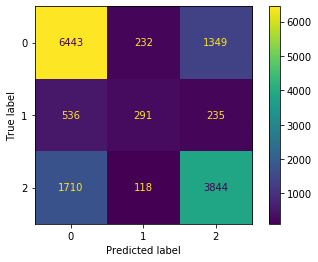

In [72]:
model_judge(tree_pipe, X_test, y_test)

Better overall accuracy. Better recall on nonfunctional wells. Bottom left and bottom right cells both show improvement. Class 1 has very few true-positives but it's not the most important.

## Random Forest

In [74]:
rf_pipe = Pipeline([('SS' , StandardScaler()),
                    ('RF' , RandomForestClassifier(random_state=0))])

In [75]:
rf_grid = [{'RF__max_depth' : [None, 5, 10, 15]},
           {'RF__min_samples_split' : [2, 10, 20]},
           {'RF__min_samples_leaf' : [1, 5, 10]}]

In [76]:
rf_gridsearch = GridSearchCV(estimator=rf_pipe, param_grid=rf_grid, scoring='accuracy', cv=3)

In [77]:
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('SS', StandardScaler()),
                                       ('RF',
                                        RandomForestClassifier(random_state=0))]),
             param_grid=[{'RF__max_depth': [None, 5, 10, 15]},
                         {'RF__min_samples_split': [2, 10, 20]},
                         {'RF__min_samples_leaf': [1, 5, 10]}],
             scoring='accuracy')

In [79]:
rf_gridsearch.best_params_

{'RF__min_samples_split': 10}

In [81]:
rf_pipe['RF'].min_samples_split = 10

In [82]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('SS', StandardScaler()),
                ('RF',
                 RandomForestClassifier(min_samples_split=10, random_state=0))])

### Scoring

                  precision    recall  f1-score   support

            func       0.77      0.87      0.82      8024
func need repair       0.60      0.25      0.35      1062
         nonfunc       0.78      0.72      0.75      5672

        accuracy                           0.77     14758
       macro avg       0.72      0.61      0.64     14758
    weighted avg       0.76      0.77      0.76     14758



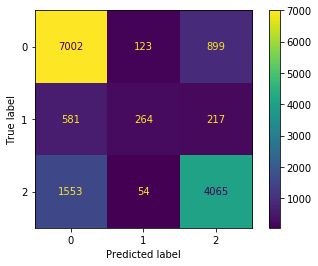

In [83]:
model_judge(rf_pipe, X_test, y_test)

Again we're seeing improvements for the nonfunctional class. With the highest precision and recall yet. And once again, we're seeing this at what seems to be the expense of the functional-needs-repair class.

## Gradient Boosting

In [91]:
grad_pipe = Pipeline([('SS' , StandardScaler()),
                     ('GB', GradientBoostingClassifier(random_state=0))])

In [92]:
grad_grid = [{'GB__max_depth' : [None, 5, 10, 15]},
             {'GB__learning_rate' : [0.1, 0.01, 0.001]}]

In [93]:
grad_gridsearch = GridSearchCV(estimator=grad_pipe, param_grid=grad_grid, scoring='accuracy', cv=3)

In [94]:
grad_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('SS', StandardScaler()),
                                       ('GB',
                                        GradientBoostingClassifier(random_state=0))]),
             param_grid=[{'GB__max_depth': [None, 5, 10, 15]},
                         {'GB__learning_rate': [0.1, 0.01, 0.001]}],
             scoring='accuracy')

In [96]:
grad_gridsearch.best_params_

{'GB__max_depth': 10}

In [97]:
grad_pipe['GB'].max_depth = 10

In [98]:
grad_pipe.fit(X_train, y_train)

Pipeline(steps=[('SS', StandardScaler()),
                ('GB',
                 GradientBoostingClassifier(max_depth=10, random_state=0))])

### Scoring

                  precision    recall  f1-score   support

            func       0.76      0.87      0.81      8024
func need repair       0.56      0.27      0.36      1062
         nonfunc       0.78      0.70      0.74      5672

        accuracy                           0.76     14758
       macro avg       0.70      0.61      0.64     14758
    weighted avg       0.75      0.76      0.75     14758



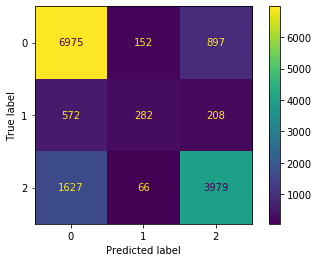

In [99]:
model_judge(grad_pipe, X_test, y_test)

Okay so this model took so long and didn't do much better than the previous one. 1pp less accurate overall, and pretty comparable recall overall. It's obvious by now that the RandomForestClassifier performed best, but just to be more methodical about it, we'll look at a DataFrame of all the model performances together in the following section.

## Pickling Trained Models

In [40]:
import pickle

Dumping out:

In [120]:
knn_name = 'knn_model.sav'
pickle.dump(knn_pipe, open(knn_name, 'wb'))

In [121]:
tree_name = 'tree_model.sav'
pickle.dump(tree_pipe, open(tree_name, 'wb'))

In [123]:
rf_name = 'rf_model.sav'
pickle.dump(rf_pipe, open(rf_name, 'wb'))

In [124]:
grad_name = 'grad_model.sav'
pickle.dump(grad_pipe, open(grad_name, 'wb'))

Loading in on next day:

In [43]:
knn_model = pickle.load(open('knn_model.sav', 'rb'))

In [46]:
tree_model = pickle.load(open('tree_model.sav', 'rb'))

In [47]:
rf_model = pickle.load(open('rf_model.sav', 'rb'))

In [48]:
grad_model = pickle.load(open('grad_model.sav', 'rb'))

# Conclusion

We saw that the **RandomForestClassifier performed the best,** with an overall **77% accuracy.** This model also had **78% precision and 72% recall on nonfunctional wells,** which I believe is the most important target value in this problem. Since this model had the best scores for nonfunctional wells, it has effectively "won."

None of the models performed exceptionally well on **functional-needs-repair wells** and I think is largely because of the class imbalance. Even when using SMOTE on the KNN model, we saw little increase in performance here. I believe that:
1. More data needs to be collected for this class.
1. This class's similarity to either of the two "bookend" classes (in that is is a liminal stage between the classes 0 and 2, rather than something discrete) contributed *greatly* to this classification problem.

If given more time, this func-need-repair problem would be more thoroughly investigated. Moreover, RF model hyperparameters would be fine tuned to get the highest possible recall for nonfunctional wells.

# Appendix - Further Data Visualizations

RandomForestClassifier model feature importances.

In [116]:
feat_df = pd.DataFrame(rf_model['RF'].feature_importances_)

In [117]:
feat_df['feature'] = dum_df.drop("status_group", axis=1).columns

In [118]:
feat_df.rename(columns = {0 : 'importance'}, inplace=True)

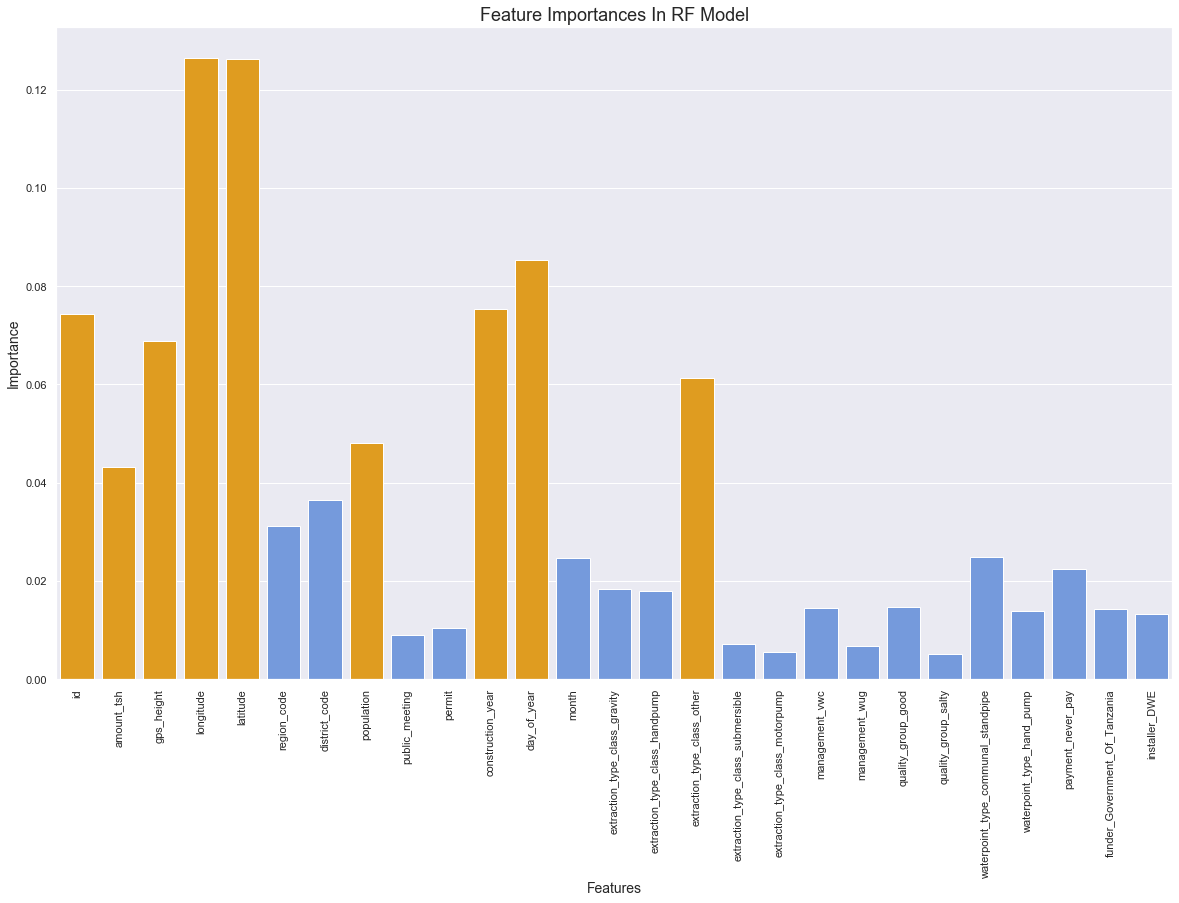

In [124]:
sns.set()

plt.figure(figsize=(20,12))
colors = ["cornflowerblue" if (x < 0.04) else 'orange' for x in feat_df['importance']] 
fig = sns.barplot(data=feat_df, x='feature', y='importance', palette=colors)
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90)
fig.set_xlabel("Features", fontsize=14)
fig.set_ylabel("Importance", fontsize=14)
fig.set_title("Feature Importances In RF Model", fontsize=18);

Map of well condition based on location within Tanzania.

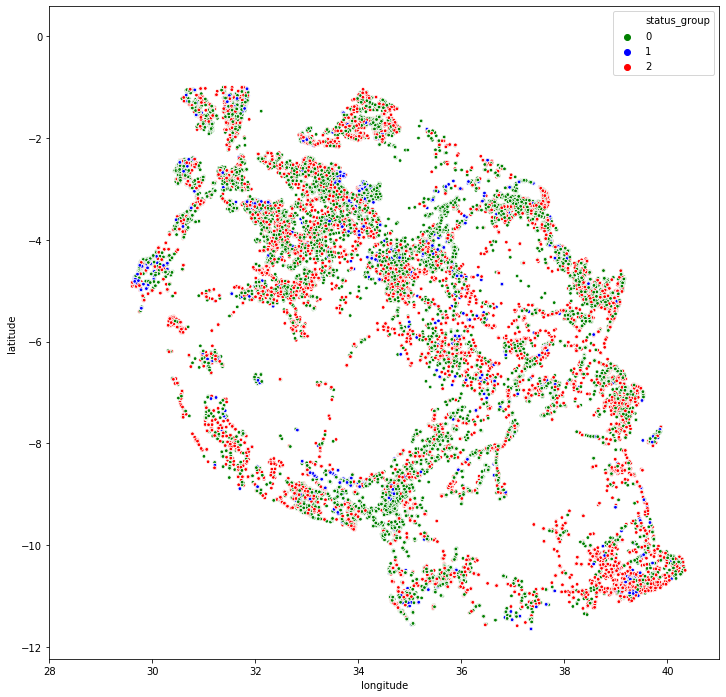

In [20]:
# sns.set(style='whitegrid')
plt.figure(figsize=(12,12))
sns.scatterplot(x=df.longitude, y=df.latitude, hue=df.status_group, palette=['green', 'blue', 'red'], s=13)
plt.xlim(28, 41);

Both of these graphics are images of the baseline decision tree running rampant. Printed out simply to admire their glitchy beauty. Enjoy.

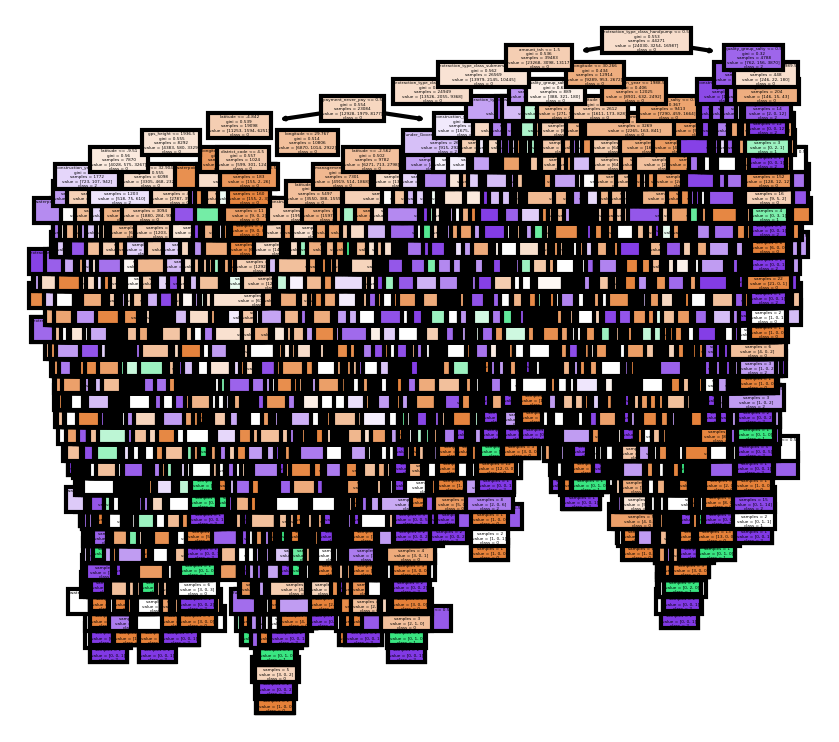

In [54]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(tree_clf,
               feature_names = dum_df.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

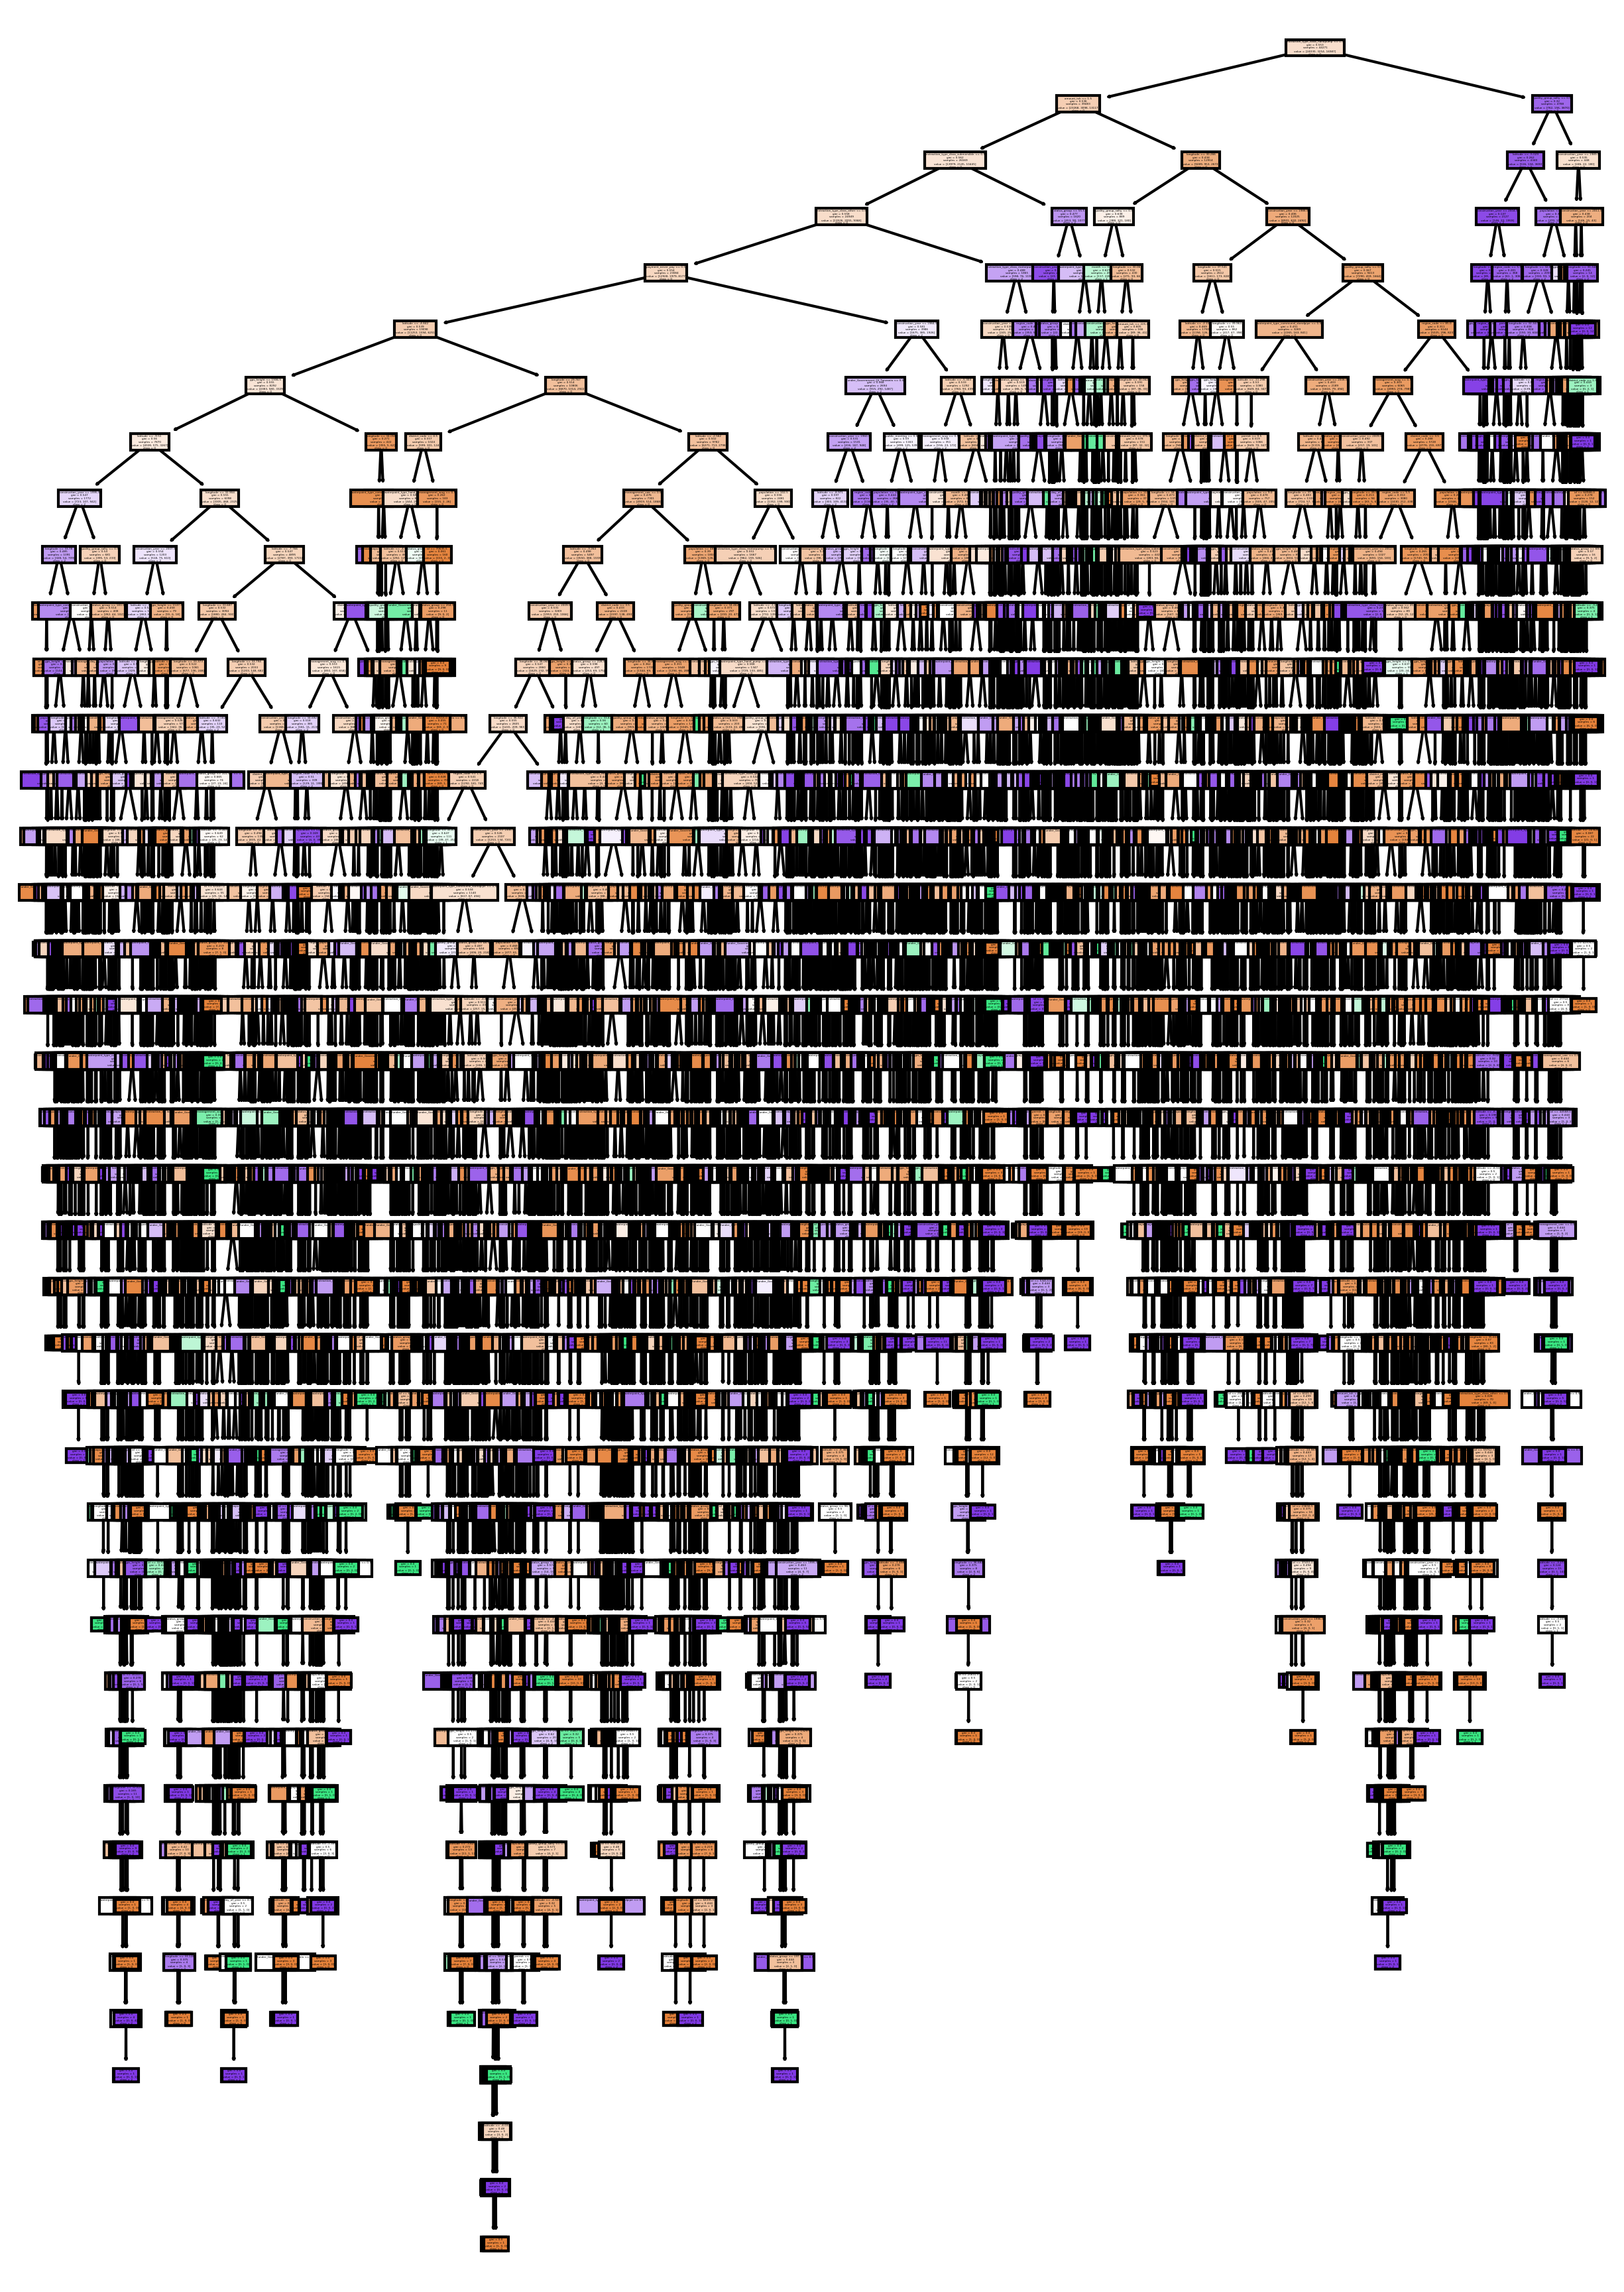

In [61]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,15), dpi=300)
tree.plot_tree(tree_clf,
               feature_names = dum_df.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()